In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
import os
import numpy as np
import math
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

* Q1 - rebalance portfolio 
* Q2 - define period for which we take into account the size (Market Cap) - moving average of the size over the period Rebalancing every month
* Q3 - Add rebalancing every REB months e.g. every 12 months, so you keep the same portfolio composition for 12 months each time.
* Q4 - change percentage of companies taken to each of 2 portfolios

Downloading Risk free rate ratio for performance calculations

In [2]:
fama = pd.read_csv(r"F-F_Research_Data_Factors.csv", sep=';')
fama['Date'] = pd.to_datetime(fama['Date'].astype('string'), format='%Y%m')
fama.set_index('Date', inplace=True)
fama.index = fama.index.to_period('m')
# Values given in CSV are plain percentages - division by 100
fama = fama.divide(100)
fama=fama[(fama.index>'2000-11')& (fama.index<'2021-01')]
fama.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-08,0.0763,-0.0022,-0.0295,0.0001
2020-09,-0.0363,0.0004,-0.0268,0.0001
2020-10,-0.0210,0.0436,0.0421,0.0001
2020-11,0.1247,0.0582,0.0214,0.0001
2020-12,0.0463,0.0489,-0.0151,0.0001


In [3]:

def pull_stock_data(tickers:str, start:str, end:str, interval:str, stripdateindex:str, column:str) -> pd.DataFrame:
    """
    Returns a dataframe with chosen stock information for last day of the month.

    Parameters:
    -------------
    tickers (str): Yahoo finance tickers for companies divided ONLY by single space
    start (str): start date of the period (format yyyy-mm-dd)
    end (str): end date of the period (format yyyy-mm-dd)
    interval (str): wanted interval (1d, 1m, 1y)
    stripdateindex (str): argument for stripping datetime index down (d - day, m - month, y- year)
    columns (list): list of wanted values, args same as in yahoo finance
    """
    # data download
    df = yf.download(tickers = tickers, start = start, end = end, interval = interval, groupby = 'ticker')
    # changing index from datetime to just year and month
    df['Date'] = df.index
    dfg = df.groupby([df.index.year, df.index.month], as_index=False).last()
    dfg.reset_index(inplace=True, drop=True)
    dfg.set_index('Date', inplace=True)
    dfg.index = pd.to_datetime(dfg.index).to_period(stripdateindex)
    # dropping na rows
    dfg.dropna(inplace = True)
    return dfg[column]

    
def save_to_desktop(dataframe:pd.DataFrame, file_name:str):
    """
    Saves dataframe to desktop in csv format under filename provided

    Parameters:
    ------------
    dataframe (pd.DataFrame): dataframe that is to be saved
    file_name (str): name of the file
    """
    # defining path to desktop on running unit
    desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
    # saving file under chosen name on desktop
    dataframe.to_csv(desktop+'/'+file_name+'.csv', sep=';')


In [4]:
tick = "NKE MSFT XOM INTC CAT WMT JPM F UPS MKC" # stocks universe
st = '2000-12-01'
en = '2020-12-31'
intv = '1d'
strpdt = 'm'
col = ['Close', 'Volume']

stocks_data = pull_stock_data(tick, st, en, intv, strpdt, col)
stocks_data.info()

[*********************100%***********************]  10 of 10 completed
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 241 entries, 2000-12 to 2020-12
Freq: M
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, CAT)    241 non-null    float64
 1   (Close, F)      241 non-null    float64
 2   (Close, INTC)   241 non-null    float64
 3   (Close, JPM)    241 non-null    float64
 4   (Close, MKC)    241 non-null    float64
 5   (Close, MSFT)   241 non-null    float64
 6   (Close, NKE)    241 non-null    float64
 7   (Close, UPS)    241 non-null    float64
 8   (Close, WMT)    241 non-null    float64
 9   (Close, XOM)    241 non-null    float64
 10  (Volume, CAT)   241 non-null    int64  
 11  (Volume, F)     241 non-null    int64  
 12  (Volume, INTC)  241 non-null    int64  
 13  (Volume, JPM)   241 non-null    int64  
 14  (Volume, MKC)   241 non-null    int64  
 15  (Volume, MSFT)  241 non-null    int

calculating the stock returns

In [5]:
# we will not need Volume - will use Market Cap instead
stocks_data = stocks_data.drop(stocks_data.filter(regex='Volume').columns, axis=1)
stocks_data['Close'] = stocks_data['Close'].pct_change()

### Market Capitalization
* data retrieved from Bloomberg with daily frequency - need to resample it to 1 month (last day of each month) and join to data frame

In [6]:
mkt_cap = pd.read_excel("mkt_cap_G2.xlsx", parse_dates = True) #we have it in easy format so pandas will handle date parsing
# rename columns to match the ones in returns data frame - luckily Bloomberg tickers are the same, just with "US EQUITY" added
mkt_cap = mkt_cap.rename(columns={c : c.partition(" ")[0] for c in mkt_cap.columns})
# Get data, only for the last day of each month (and year ofc)
mth_mkt_cap = mkt_cap.groupby([mkt_cap['Date'].dt.year, mkt_cap['Date'].dt.month], as_index=False).last().set_index("Date")
# make index have the same format as in stocks_data
mth_mkt_cap.index = mth_mkt_cap.index.to_period("m")
# create MultiIndex for Market Cap and each company
mth_mkt_cap.columns = pd.MultiIndex.from_product([["MktCap"], mth_mkt_cap.columns])
# join MktCap to stocks_data
stocks_data = stocks_data.join(mth_mkt_cap, on=["Date"])
stocks_data.head()

Close                                                              \
              CAT         F      INTC       JPM       MKC      MSFT       NKE   
Date                                                                            
2000-12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2001-01 -0.065363  0.202773  0.230769  0.210234  0.010745  0.407781 -0.014379   
2001-02 -0.059249 -0.013480 -0.228041 -0.151482  0.078189 -0.033777 -0.290493   
2001-03  0.066827  0.011147 -0.078775 -0.037720  0.068448 -0.073093  0.033820   
2001-04  0.131140  0.048364  0.174727  0.068597 -0.064063  0.238857  0.036183   

                                           MktCap                          \
              UPS       WMT       XOM         CAT           F        INTC   
Date                                                                        
2000-12       NaN       NaN       NaN  16263.8134  44443.0234  202320.625   
2001-01  0.053617  0.069176 -0.032063  15200.7572  53454.8834  249010.000   
2001-02 -0.086753 -0.118134 -0.036839  14300.1244  52734.3138  192225.625   
2001-03  0.006545  0.008185 -0.000617  15239.9495  51601.6286  176767.375   
2001-04  0.009666  0.024554  0.093827  17233.6594  56037.1191  207653.380   

                                                                      \
                 JPM        MKC         MSFT         NKE         UPS   
Date                                                                   
2000-12   59539.5761  2391.9712  231290.1560  15072.8352  66471.9433   
2001-01  106048.2150  2423.6188  325463.1250  14836.3903  70035.9709   
2001-02   89983.8100  2586.4043  314788.0469  10528.0554  61257.7120   
2001-03   88625.5953  2754.3177  291779.1748  10932.4622  63622.2866   
2001-04   94705.0348  2611.0851  361472.7148  11338.7800  64957.4753   

                                   
                 WMT          XOM  
Date                               
2000-12  237291.5543  302194.7500  
2001-01  253706.5465  292505.4000  
2001-02  223735.2518  281729.8000  
2001-03  225566.5845  279888.1436  
2001-04  231301.7500  306149.2533

### Not necessary
calculating stock excess return - *not sure if that's actually needed*

In [6]:
fama = pd.read_csv(r"F-F_Research_Data_Factors.CSV", sep=';')
fama['Date'] = pd.to_datetime(fama['Date'].astype('string'), format='%Y%m')
fama.set_index('Date', inplace=True)
fama.index = fama.index.to_period('m')
# Values given in CSV are plain percentages - division by 100
fama = fama.divide(100)
fama.head()


,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,0.0296,-0.0256,-0.0243,0.0022
1926-08,0.0264,-0.0117,0.0382,0.0025
1926-09,0.0036,-0.0140,0.0013,0.0023
1926-10,-0.0324,-0.0009,0.0070,0.0032
1926-11,0.0253,-0.0010,-0.0051,0.0031


In [7]:
# Join risk free rates to stock returns in periods
# dffull = pd.merge(stocks_data,fama, how='left', left_index=True, right_index=True)
# # drop first NULL row which is causing regression to fail
# dffull = dffull.dropna()

In [8]:
# Calculate excess stock return for each company
# for i in dffull.columns.tolist()[:10]:
#     dffull[i+'_re'] = dffull[i]-dffull['RF']
# # Calculate excess Market return
# dffull['reM'] = dffull['Mkt-RF']-dffull['RF']
# dffull.info()

### Portfolio building functions

periods (PS) wyznacza od kiedy robimy rebalancing (bo musimy zebrać dane pod to)
Piersze PS periodów powinno być widoczne w DataFrame ale mieć NaN (aby shape się zgadzał)

In [7]:
# reshape DataFrame
c = stocks_data['Close'].melt(ignore_index=False, value_name="return", var_name='company') #.reset_index()
s = stocks_data['MktCap'].melt(ignore_index=False, value_name="mkt_cap", var_name='company')
df = pd.merge(c, s, on=["Date",'company'])
df

,company,return,mkt_cap
Date,,,
2000-12,CAT,NaN,16263.8134
2001-01,CAT,-0.065363,15200.7572
2001-02,CAT,-0.059249,14300.1244
2001-03,CAT,0.066827,15239.9495
2001-04,CAT,0.131140,17233.6594
...,...,...,...
2020-08,XOM,-0.050856,168875.6375
2020-09,XOM,-0.140461,145155.2488
2020-10,XOM,-0.049811,137924.9699


In [8]:
def rebalance(df_slice, sort_var, p1, p2):
    """
    Rebalancing returns a list of 2 (for now) portfolios based on the value of decision variable in period taken into account. 
    Period is defined by the length of df_slice.
    p1, p2 - percentages given to each class of companies, they are in ASCENDING order, so the higher portfolio number the bigger the sort_var value
    TODO: Adjust to return "n" portfolios - this would require changing to sth more sophisticated than head/tail and adjusting form in which percentages are given
    """
    # 1st part - decide on size of each portoflio - based on universe size and percentages assigned to each class of stocks (p1, p2)
    universe_size = df_slice['company'].nunique()
    small_cnt = int((universe_size*p1)//1)
    big_cnt = round(universe_size*p2)

    period_avg = df_slice.groupby('company').mean().reset_index()
    # SORTING by variable - biggest values are in the BOTTOM of dataframe
    temp_sort = period_avg.sort_values(sort_var, ascending = True)
    # probably some loop over every percentage to get proper companies from sorted list
    # we need to return only the names of companies, because the values of returns at this stage are already aggregated for the whole `period`
    small_comp = temp_sort.head(small_cnt)['company'].values
    big_comp = temp_sort.tail(big_cnt)['company'].values

    return [small_comp, big_comp]


def get_portfolio_stats(date, portfolios, df, sort_var):
    """
    portfolios - list of lists of company tickers. The portfolios are increasing order with respect to decision variable value. (P2 will have greater `size` than P1)
    We are interested in average size (mkt_cap), average return and composition of each portfolio
    Function iterates over list of portfolios and calculates metrics for each of them assuming they are equally weighted
    Returns dict of statistics with portfolio number which is used later to construct pd.DataFrame
    """
    ptfs = {}
    for idx, p in enumerate(portfolios, 1):
        p_period_df = df.loc[(df.index == date) & (df.company.isin(p))]
        
        p_name = "ptf_" + str(idx)
        ptfs[p_name+"_return"] = p_period_df['return'].mean()
        ptfs[p_name+"_"+sort_var] = p_period_df[sort_var].mean()
        ptfs[p_name+"_stocks"] = p

    return ptfs

def constrcut_portfolios(df, decision_var, reb, per, small_p, big_p):
    """
    Function that simulates the process of constructing portfolios according to decision variable. 
    It assumes that each period is the end of month for which data is available (so at time "T" we already now the values of decision_var at period "T")
    df - DataFrame in long format with stocks under "company" column
    reb - rebalancing period, how often we change composition of portfolios
    per - defines how many periods are taken into account when rebalancing. First rebalance happens after per periods past (to gather data)
    small_p - percentage of stocks considered as "small" or "big" based on decision variables (low/high) would be more generalized naming
    """
    portfolios = []
    test_l = []
    first_reb = True
    reb_counter = 0
    
    for p_idx, d in enumerate(df.index.unique(), 1):
        reb_counter += 1
        
        if (not first_reb and reb_counter%reb == 0) or (first_reb and p_idx==per):
            # define slice based on periods taken into account for rebalancing decision (rebalancing could be every 12 months, but periods considered could be e.g. 6 months)
            # print(reb_counter, "rebalance", d)
            slice = df[(df.index >= d - per+1) & (df.index <= d)]
            # return portfolios after rebalancing
            portfolios = rebalance(slice, decision_var, small_p, big_p)

            # a couple of settings after first rebalancing
            if first_reb and p_idx==per:
                first_reb = False
                reb_counter = 0 #start counting until next rebalancing from zero 
        
        # this is done for each period 
        # calculation of metrics
        stats = get_portfolio_stats(d, portfolios, df, decision_var)
        test_l.append(stats)
    
    return pd.DataFrame(test_l, index=df.index.unique())


QUESTION 1 - portfolios sorted based on the past size of company.
p1 - 50% smallest (by mkt_cap) stocks in t-1,
p2 - 50% biggest (by mkt_cap) stocks in t-1

In [9]:
Q1 = constrcut_portfolios(df=df, decision_var="mkt_cap", reb=1, per=1, small_p=.5, big_p=.5)
Q1

,ptf_1_return,ptf_1_mkt_cap,ptf_1_stocks,ptf_2_return,ptf_2_mkt_cap,ptf_2_stocks
Date,,,,,,
2000-12,NaN,27542.24386,"[MKC, NKE, CAT, F, JPM]",NaN,207913.80572,"[UPS, INTC, MSFT, WMT, XOM]"
2001-01,0.037479,31190.32412,"[MKC, NKE, CAT, F, UPS]",0.177179,245346.65730,"[JPM, INTC, WMT, XOM, MSFT]"
2001-02,-0.074357,28281.32198,"[MKC, NKE, CAT, F, UPS]",-0.113654,220492.50674,"[JPM, INTC, WMT, XOM, MSFT]"
2001-03,0.037357,28830.12892,"[MKC, NKE, CAT, F, UPS]",-0.036404,212525.37464,"[JPM, INTC, WMT, XOM, MSFT]"
2001-04,0.032258,30435.62378,"[MKC, NKE, CAT, F, UPS]",0.120112,240256.42658,"[JPM, INTC, WMT, XOM, MSFT]"
...,...,...,...,...,...,...
2020-08,0.051196,88357.68934,"[F, MKC, CAT, UPS, XOM]",0.084723,559303.05524,"[NKE, INTC, JPM, WMT, MSFT]"
2020-09,-0.031228,84437.50482,"[MKC, F, CAT, UPS, XOM]",0.007879,539523.28956,"[NKE, INTC, JPM, WMT, MSFT]"
2020-10,0.007334,82686.58252,"[MKC, F, CAT, UPS, XOM]",-0.043122,518541.63858,"[INTC, NKE, JPM, WMT, MSFT]"


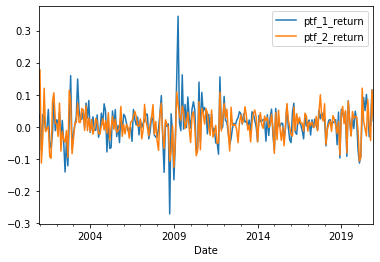

In [10]:
Q1[['ptf_1_return', 'ptf_2_return']].plot()
plt.show()

Calculating performance measures of portfolios- Sharpe Ratio and Jensen Measure

In [11]:
# Join risk free rates to stock returns in periods
dffull = pd.merge(Q1,fama, how='left', left_index=True, right_index=True)

In [27]:
# Calculate excess portfolio return for each portfolio
portfolio_list=['ptf_1_return', 'ptf_2_return']
for i in dffull[portfolio_list]:
    dffull[i+'_re'] = dffull[i]-dffull['RF']
# Calculate excess Market return
dffull['reM'] = dffull['Mkt-RF']-dffull['RF']
dffull.info()
dffull=dffull.iloc[1:,:]

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 241 entries, 2000-12 to 2020-12
Freq: M
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ptf_1_return     240 non-null    float64
 1   ptf_1_mkt_cap    241 non-null    float64
 2   ptf_1_stocks     241 non-null    object 
 3   ptf_2_return     240 non-null    float64
 4   ptf_2_mkt_cap    241 non-null    float64
 5   ptf_2_stocks     241 non-null    object 
 6   Mkt-RF           241 non-null    float64
 7   SMB              241 non-null    float64
 8   HML              241 non-null    float64
 9   RF               241 non-null    float64
 10  ptf_1_return_re  240 non-null    float64
 11  ptf_2_return_re  240 non-null    float64
 12  reM              241 non-null    float64
dtypes: float64(11), object(2)
memory usage: 34.5+ KB


In [32]:
def get_significance(pvalue):
    '''
    Helper function to make p-value visual with use of stars
    '''
    if pvalue > 0.1: return ''
    elif pvalue > 0.05: return '*'
    elif pvalue> 0.01: return '**'
    else: return '***'

In [33]:
def reg_it(df:pd.DataFrame, list_of):
    # Exog variable is constant - it's always Excess Market return
    X = sm.add_constant(df['reM'])
    # Store results in dict
    reg_results = {}
    for portfolio in list_of:
        y = df[portfolio]
        reg_model = sm.OLS(y, X).fit(cov_type='HC3')
        CAPM_params = {'AVG_excess_return' : y.mean(), 
            "alpha" : reg_model.params[0], #to reg model cos nie d 
            "beta" : reg_model.params[1],
            "beta_pvalue" : get_significance(reg_model.pvalues[1]),
            "R2adj" : reg_model.rsquared_adj,
        }
        reg_results[portfolio[:-3]] = CAPM_params
    
    results_df = pd.DataFrame.from_dict(reg_results, orient='index')
    # Save it to .csv in our folder (you can copy from this output dataframe and paste to excel directly tough...)
    # results_df.to_csv('Q1_results.csv', sep=';')
    return results_df

In [34]:
colsreg = ['ptf_1_return_re','ptf_2_return_re']
results_df1=reg_it(dffull, colsreg)
print(results_df1)

              AVG_excess_return     alpha      beta beta_pvalue     R2adj
ptf_1_return           0.008103  0.002697  1.017777         ***  0.632552
ptf_2_return           0.006122  0.001484  0.873225         ***  0.693885


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
def calc_perf(df, reg_df):
    '''
    Function calculating performance metrics 
    
    Parameters:
    df -> dataframe with stock excess returns
    reg_df -> regressions output dataframe with alphas and betas for each portfolio
    '''

    # create an empty list to be filled with sharpe ratio
    sr = list()
    tr = list()

    # loop through portfolio excess returns and calculate Sharpe ratio and Treynor ratio for each, append to list. Jensens alpha will be just the intercept from the reg_df
    for i in df[['ptf_1_return', 'ptf_2_return']]
        sr.append(
            df[i+'_re'].mean() / np.std(df[i+'_re'])
            )   
        tr.append(
            df[i+'_re'].mean() / reg_df.loc[i, "beta"]
            )

    return [sr, tr, list(reg_df['alpha'].values)]

In [51]:
res_q1=calc_perf(dffull, results_df1)

QUESTION 2 - portfolios sorted based on the average past size of company in previous n periods.
p1 - 50% smallest (by mkt_cap) stocks in t-1,
p2 - 50% biggest (by mkt_cap) stocks in t-1

In [12]:
# in thissetting we don't construct portfolios until 6 months of data is available 
# then rebalance them every month, but considering 6 period rolling average size
Q2 = constrcut_portfolios(df=df, decision_var="mkt_cap", reb=1, per=6, small_p=.5, big_p=.5)
Q2

,ptf_1_return,ptf_1_mkt_cap,ptf_1_stocks,ptf_2_return,ptf_2_mkt_cap,ptf_2_stocks
Date,,,,,,
2000-12,NaN,NaN,NaN,NaN,NaN,NaN
2001-01,NaN,NaN,NaN,NaN,NaN,NaN
2001-02,NaN,NaN,NaN,NaN,NaN,NaN
2001-03,NaN,NaN,NaN,NaN,NaN,NaN
2001-04,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-08,0.090626,89489.74778,"[F, MKC, CAT, UPS, NKE]",0.045293,558170.99680,"[XOM, INTC, JPM, WMT, MSFT]"
2020-09,0.021263,94572.13674,"[F, MKC, CAT, UPS, NKE]",-0.044612,529388.65764,"[XOM, INTC, JPM, WMT, MSFT]"
2020-10,0.007334,82686.58252,"[MKC, F, CAT, UPS, XOM]",-0.043122,518541.63858,"[NKE, INTC, JPM, WMT, MSFT]"


In [ ]:
# Join risk free rates to stock returns in periods
dffull2 = pd.merge(Q2,fama, how='left', left_index=True, right_index=True)

In [ ]:
# Calculate excess portfolio return for each portfolio
for i in dffull2[portfolio_list]:
    dffull2[i+'_re'] = dffull2[i]-dffull2['RF']
# Calculate excess Market return
dffull2['reM'] = dffull2['Mkt-RF']-dffull2['RF']
dffull2.info()

In [ ]:
results_df2=reg_it(dffull2, colsreg)
print(results_df2)

In [ ]:
res_q2=calc_perf(dffull2, results_df2)

QUESTION 3 - portfolios sorted based on the average past size of company in previous n periods, portfolio components change every REB periods.
p1 - 50% smallest (by size) stocks in t-1,
p2 - 50% biggest (by size) stocks in t-1

In [39]:
# left it here to spot difference between decision variables Volume vs. MktCap
Q3 = constrcut_portfolios(df=df, decision_var="mkt_cap", reb=12, per=6, small_p=.5, big_p=.5)
Q3

,ptf_1_return,ptf_1_mkt_cap,ptf_1_stocks,ptf_2_return,ptf_2_mkt_cap,ptf_2_stocks
Date,,,,,,
2000-12,NaN,NaN,NaN,NaN,NaN,NaN
2001-01,NaN,NaN,NaN,NaN,NaN,NaN
2001-02,NaN,NaN,NaN,NaN,NaN,NaN
2001-03,NaN,NaN,NaN,NaN,NaN,NaN
2001-04,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-08,0.090626,89489.74778,"[MKC, F, CAT, UPS, NKE]",0.045293,558170.99680,"[XOM, INTC, WMT, JPM, MSFT]"
2020-09,0.021263,94572.13674,"[MKC, F, CAT, UPS, NKE]",-0.044612,529388.65764,"[XOM, INTC, WMT, JPM, MSFT]"
2020-10,0.008597,92802.54256,"[MKC, F, CAT, UPS, NKE]",-0.044386,508425.67854,"[XOM, INTC, WMT, JPM, MSFT]"


In [ ]:
Q3 = constrcut_portfolios(df=df, decision_var="mkt_cap", reb=12, per=6, small_p=.5, big_p=.5)
Q3

In [ ]:
# Join risk free rates to stock returns in periods
dffull3 = pd.merge(Q3,fama, how='left', left_index=True, right_index=True)

In [ ]:
# Calculate excess portfolio return for each portfolio
for i in dffull3[portfolio_list]:
    dffull3[i+'_re'] = dffull3[i]-dffull3['RF']
# Calculate excess Market return
dffull3['reM'] = dffull3['Mkt-RF']-dffull3['RF']
dffull3.info()

In [ ]:
results_df3=reg_it(dffull3, colsreg)
print(results_df3)

In [ ]:
res_q3=calc_perf(dffull3, results_df3)

QUESTION 4 - portfolios sorted based on the average past size of company in previous n periods, portfolio components change every REB periods.
p1 - 30% smallest (by size) stocks in t-1,
p2 - 30% biggest (by size) stocks in t-1

In [ ]:
Q4 = constrcut_portfolios(df=df, decision_var="mkt_cap", reb=12, per=6, small_p=.3, big_p=.3)
Q4

In [ ]:
# Join risk free rates to stock returns in periods
dffull4 = pd.merge(Q4,fama, how='left', left_index=True, right_index=True)

In [ ]:
# Calculate excess portfolio return for each portfolio
for i in dffull4[portfolio_list]:
    dffull4[i+'_re'] = dffull4[i]-dffull4['RF']
# Calculate excess Market return
dffull4['reM'] = dffull4['Mkt-RF']-dffull4['RF']
dffull3.info()

In [ ]:
results_df4=reg_it(dffull4, colsreg)
print(results_df4)

In [ ]:
res_q4=calc_perf(dffull4, results_df4)

___